# Make anaphase time predictions based on the instataneous surface only with a linear regression model

First attempt to predict the anaphase time based on the time series of the relative surface feature only. We will use simple simple machine learning algorithms to make our predictions as a first attempt. Here we use bivariate linear regression as a model.

Problem formulation $\forall$ division event $i$, $\forall 0< t < t^*$, we want to predict the target variable $y_{i, t} = t_i^* - t$ , the relative time to anaphase(TTA), based on the present feature, $X_{i, t}$ ; i.e. we want $$f : X_{i, t} \mapsto y_{i, t} = t_i^* - t \in \mathbb{R_+^*}$$

This is regression problem, and we will use the classical MSE as a loss function/evaluation metrics.

In [1]:
%matplotlib inline
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from skimage import measure # to get contours from masks
import sklearn

import napari

sns.set_theme()

C:\ProgramData\Anaconda3\lib\site-packages\napari\_qt\__init__.py:37: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


## Loading Data

In [2]:
os.chdir("D:/Hugo/Anaphase/Analyse_Descriptive")
data = pd.read_csv("Analysis_BF_f0001-1-100.1.csv", sep=";", comment="#")
data = data[data["time_to_anaphase"] >= 0]

print(data.shape)
data.head()

(495, 17)


,idx,frame,time,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,relat_surf,anaphase,anaphase_int,time_to_anaphase,cum_relat_surf,delta_mom_surf,delta_daugh_surf,delta_relat_surf
0,0,0,0,463.509804,225.369863,-1.000000,-1.000000,229.730504,0.000000,0.000000,False,0,36,0.000000,-2.000015,9.534260,0.041866
1,0,1,6,463.481911,225.084507,460.542099,238.588235,227.730488,9.534260,0.041866,False,0,30,0.020842,2.000015,26.872597,0.116610
2,0,2,12,460.345420,225.602740,456.110886,239.965517,229.730504,36.406857,0.158476,False,0,24,0.066853,-5.000000,15.147087,0.070927
3,0,3,18,460.578297,225.698630,455.691877,240.914286,224.730504,51.553944,0.229403,False,0,18,0.106912,3.715675,17.147087,0.071328
4,0,4,24,461.524165,225.985915,456.054041,241.146341,228.446179,68.701031,0.300732,False,0,12,0.145739,-2.000000,13.147057,0.060714


In [5]:
# prepare the training set
from sklearn.model_selection import train_test_split

features = ["relat_surf", "delta_relat_surf"]

X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["time_to_anaphase"].values, train_size=0.9)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(445, 2) (50, 2) (445,) (50,)


## Linear regression

Here we will try to fit a linear regression to predict the TTA given the cumulative relative surface at time $t$. This is a dumb regressor, as it will not be bad on average, but learns to predict from single data points (i.e. makes the assumption that all the observations are i.i.d.) instead of taking the cell's history into account and trying to predict, at each time step of a time series, the TTA. As we will see, it will not perform bad on average (RMSE of 5 minutes) and will simply make early predictions on the points that are over the curve (latecomers) and late observations on the points which are under the curve (earlycomers). 

### Training

In [6]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(X_train, y_train)

print(f"R^2 coefficient : {round(lm.score(X_train, y_train), 2)}")

R^2 coefficient : 0.77


Text(0.5, 1.0, 'Linear regression predictions on the training set')

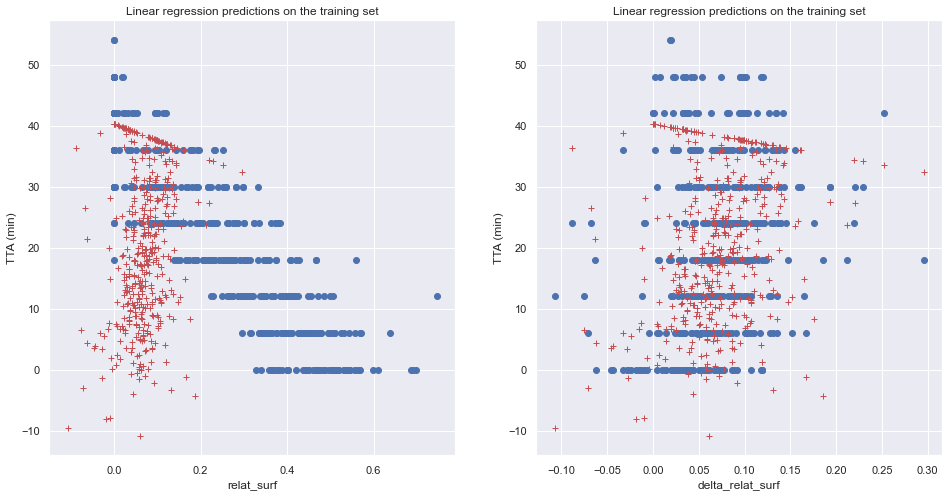

In [10]:
predictions_on_train_set = lm.predict(X_train)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# first dim
ax[0].scatter(X_train[:, 0], y_train, c='b', label="Train set")
ax[0].plot(X_train[:, 1], predictions_on_train_set, "+", c="r", label="Predictions")
ax[0].set_xlabel(features[0])
ax[0].set_ylabel("TTA (min)")
ax[0].set_title("Linear regression predictions on the training set")

# second dim
ax[1].scatter(X_train[:, 1], y_train, c='b', label="Train set")
ax[1].plot(X_train[:, 1], predictions_on_train_set, "+", c="r", label="Predictions")
ax[1].set_xlabel(features[1])
ax[1].set_ylabel("TTA (min)")
ax[1].set_title("Linear regression predictions on the training set")

In [12]:
print(f"Regression equation : {lm.coef_[0]} * {features[0]} + {lm.coef_[1]} * {features[1]} + {lm.intercept_}")

Regression equation : -70.71626805706282 * relat_surf + -26.731536968978467 * delta_relat_surf + 40.256877514804586


### Evaluation

Text(0.5, 1.0, 'Linear regression predictions on the test set')

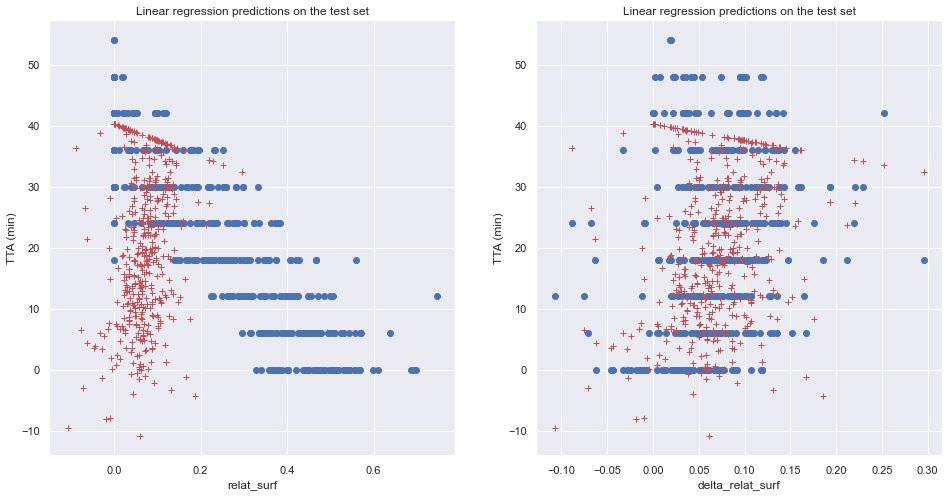

In [14]:
predictions_on_test_set = lm.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# first dim
ax[0].scatter(X_train[:, 0], y_train, c='b', label="Test set")
ax[0].plot(X_train[:, 1], predictions_on_train_set, "+", c="r", label="Predictions")
ax[0].set_xlabel(features[0])
ax[0].set_ylabel("TTA (min)")
ax[0].set_title("Linear regression predictions on the test set")

# second dim
ax[1].scatter(X_train[:, 1], y_train, c='b', label="Test set")
ax[1].plot(X_train[:, 1], predictions_on_train_set, "+", c="r", label="Predictions")
ax[1].set_xlabel(features[1])
ax[1].set_ylabel("TTA (min)")
ax[1].set_title("Linear regression predictions on the test set")

Mean squared error : 5.175867705812961


Text(0.5, 1.0, 'L2 loss given the sign of (y_true - y_pred)')

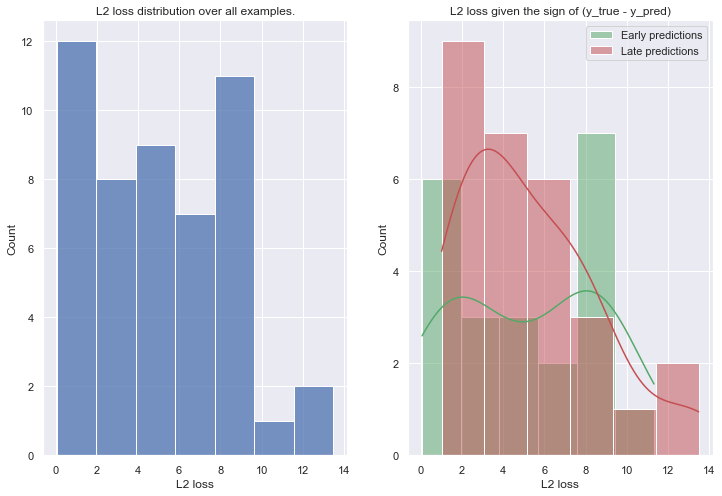

In [17]:
# evaluation with the clasical RMSE
losses, signed_losses = [], []
for obs, pred, gt in zip(X_test, predictions_on_test_set, y_test):
    loss = np.sqrt((pred - gt) ** 2)
    signed_losses.append(gt - pred)
    losses.append(loss)
losses = np.array(losses) 
signed_losses = np.array(signed_losses)

print(f"Mean squared error : {losses.mean()}")

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# RMSE distribution
sns.histplot(losses, ax=axes[0])
axes[0].set_title("L2 loss distribution over all examples.")
axes[0].set_xlabel("L2 loss")

# Conditional distributions given the sign of the error
sns.histplot(losses[signed_losses >= 0], color="g", kde=True, label="Early predictions", ax=axes[1])
sns.histplot(losses[signed_losses < 0], color="r", kde=True, label="Late predictions", ax=axes[1])
axes[1].legend()
axes[1].set_xlabel("L2 loss")
axes[1].set_title("L2 loss given the sign of (y_true - y_pred)")

## Save predictions

In [14]:
predictions = []
for i, row in data.iterrows():
    if row["time_to_anaphase"] >= 0:
        p = lm.predict(np.array(row["relat_surf"]).reshape(-1, 1))
        predictions.append(p[0])
    else:
        predictions.append(-1)
        
data["predictions_tta"] = predictions

data[:50]

,idx,frame,time,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,relat_surf,anaphase,anaphase_int,time_to_anaphase,cum_relat_surf,relat_surf_standardized,predictions_tta
0,0,0,0,463.509804,225.369863,-1.000000,-1.000000,229.730504,0.000000,0.000000,False,0,36,0.000000,0.000000,37.417033
1,0,1,6,463.481911,225.084507,460.542099,238.588235,227.730488,9.534260,0.041866,False,0,30,0.020842,0.000280,37.401585
2,0,2,12,460.345420,225.602740,456.110886,239.965517,229.730504,36.406857,0.158476,False,0,24,0.066853,0.001067,37.358559
3,0,3,18,460.578297,225.698630,455.691877,240.914286,224.730504,51.553944,0.229403,False,0,18,0.106912,0.001550,37.332389
4,0,4,24,461.524165,225.985915,456.054041,241.146341,228.446179,68.701031,0.300732,False,0,12,0.145739,0.002038,37.306070
5,0,5,30,462.524165,226.197183,456.493388,242.023256,226.446179,81.848088,0.361446,False,0,6,0.181476,0.002463,37.283668
6,0,6,36,461.312897,226.070423,454.310524,242.285714,219.446179,98.995175,0.451114,True,1,0,0.218778,0.003094,37.250583
11,1,11,0,473.698778,241.550725,-1.000000,-1.000000,192.583462,0.000000,0.000000,False,0,42,0.000000,0.000000,37.417033
12,1,12,6,471.727764,241.550725,466.226769,254.521739,186.299153,18.397072,0.098750,False,0,36,0.048556,0.000660,37.380596
13,1,13,12,471.480831,241.850746,466.521687,255.606061,183.867756,40.691246,0.221307,False,0,30,0.104999,0.001490,37.335376


In [ ]:
os.chdir("D:/Hugo/Anaphase/Analyse_Descriptive")
data.to_csv(f"LinReg_Predictions_{features}_BF_f0001-1-100.csv", sep=";")

contours